
# CNN
---
# 1 Initialization

In [ ]:
!echo "Package install"
!pip install -r requirements.txt > /dev/null 
!echo "done"

In [1]:
import tensorflow as tf
from os.path import join
from os import listdir
import numpy as np
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from media_utils import print_imgs

## 2 Loading the dataset

The dataset is loaded through a dataset import.

This is a method to make the notebook more elegant by hiding in the file `datasets/landscapes/__init__.py` the method to import all images and then return the two variables `gray_images, rgb_images` and the function `load_images`.

The shape of `gray_images` is (None, 128, 128, 1), while that of `rgb_images` is (None, 128, 128, 3).


In [2]:
from datasets.landscape import gray_images, rgb_images, load_images

Caricamento immagini
Dataset trovato in datasets/landscape
skipped datasets/landscape/__init__.py
skipped datasets/landscape/__pycache__
Caricate 4319 immagini


### 2.1 Data Randomization

The dataset is randomized to prevent bias in the data.


Eseguo uno shuffle delle immagini


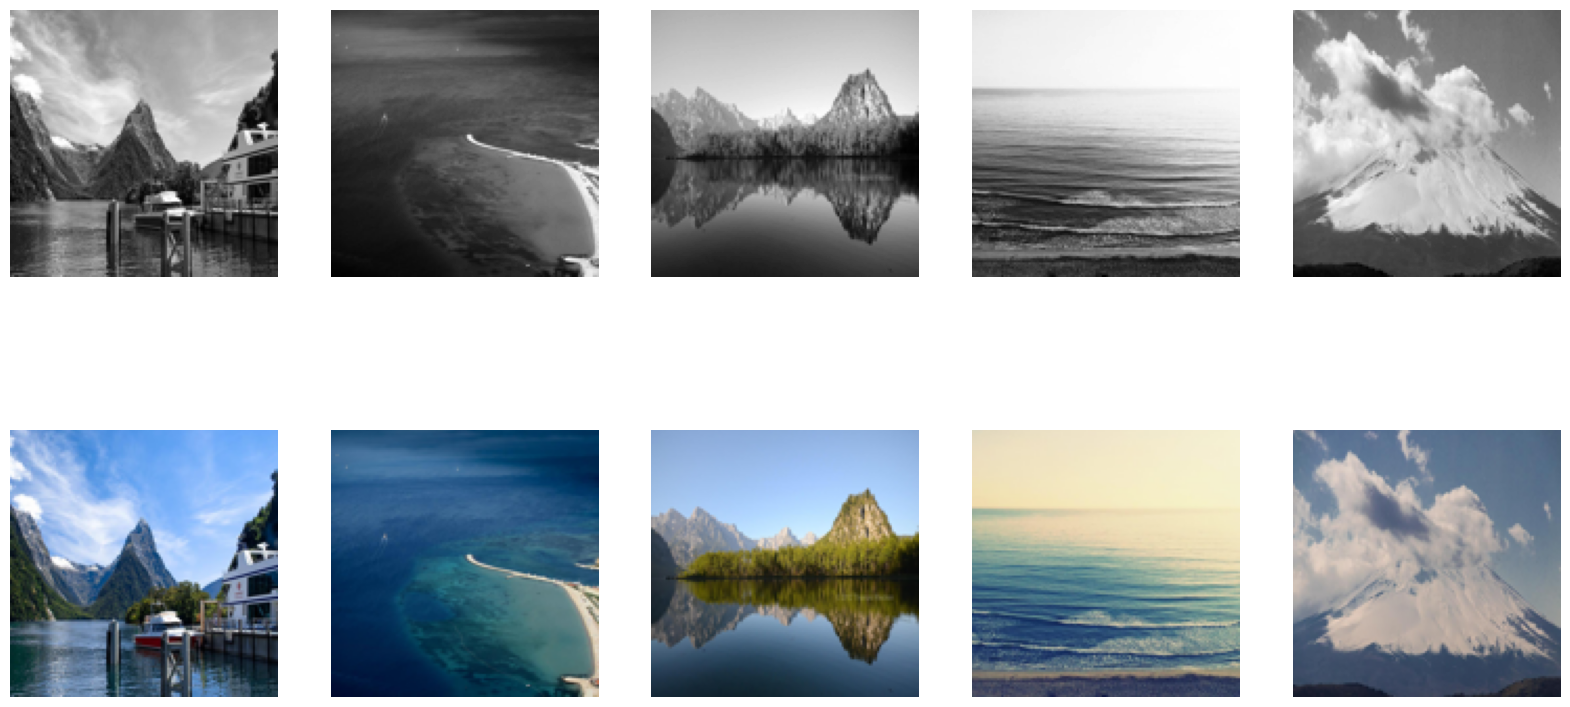

In [ ]:
x_dataset, y_dataset = gray_images, rgb_images

print('Shuffled image')
indici_shuffle = np.random.permutation(len(x_dataset))
x_dataset = x_dataset[indici_shuffle]
y_dataset = y_dataset[indici_shuffle]

print_imgs(x_dataset[:5], y_dataset[:5])

In [ ]:
print(f'Shape of x = {x_dataset.shape}, Shape of y = {y_dataset.shape}')
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=42)

dim = 20
print('SPLIT'.center(dim * 3 + 2, '='))
print(f'{" " * dim}|{"x".center(dim, " ")}|{"y".center(dim, " ")}')
print(f'{"train".ljust(dim, " ")}|{str(x_train.shape).center(dim, " ")}|{str(y_train.shape).center(dim, " ")}')
print(f'{"test".ljust(dim, " ")}|{str(x_test.shape).center(dim, " ")}|{str(x_test.shape).center(dim, " ")}')

Shape di x = (4319, 128, 128, 1), shape di y = (4319, 128, 128, 3)
============================SPLIT=============================
                    |         x          |         y          
train               |(3455, 128, 128, 1) |(3455, 128, 128, 3) 
test                | (864, 128, 128, 1) | (864, 128, 128, 1) 


## 3 Model
---
The adopted model is a convolutional network (CNN).

The network takes as input a 4-dimensional tensor: (None, 128, 128, 1).
This tensor represents the list of grayscale images (it has only the luminance channel).

Instead, it returns a 4-dimensional tensor: (None, 128, 128, 3).
This tensor represents the list of images in RGB format.

The network uses `padding='same'` because we want to keep the image in its original dimensions and we have used `strides=1` so that it analyzes the entire image without skipping pixels (which could result in losing important details).

Layers of `BatchNormalization` have been added to normalize the levels of the input for each batch, in order to make the data more stable during training.

The final `Reshape` layer shapes the complete image.

I used the `LeakyReLU` to counteract the _dying ReLU_ phenomenon, since if the input is negative the ReLU returns 0.

With LeakyReLU, it is possible to mitigate this issue by returning a value proportional to the negative input, thereby providing greater flexibility and an improved capacity to learn features.

The alpha value of 0.2 was determined empirically.

---

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Reshape, Conv2DTranspose, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers.legacy import Adam # for Mac
#from tensorflow.keras.optimizer import Adam # the classic one

model = Sequential([
    Conv2D(128, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1, input_shape=(128, 128, 1)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1),
    BatchNormalization(),
    Conv2DTranspose(512, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1),
    BatchNormalization(),
    Conv2DTranspose(256, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1),
    BatchNormalization(),
    Conv2DTranspose(256, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1),
    BatchNormalization(),
    Conv2DTranspose(128, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same', strides=1),
    BatchNormalization(),
    Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same'),
    Reshape((128, 128, 3))
])

def color_consistency_loss(y_true, y_pred):
    # mse
    mse = tf.reduce_mean(tf.square(y_true - y_pred))

    # standard deviation 
    std_true = tf.math.reduce_std(y_true, axis=-1)
    std_pred = tf.math.reduce_std(y_pred, axis=-1)

    # we add weight to the loss
    mse_weight = 0.92
    std_weight = 0.08

    # Calculate the combinated loss
    loss = mse_weight * mse + std_weight * tf.reduce_mean(tf.square(std_true - std_pred))

    return loss

model.compile(optimizer=Adam(learning_rate=0.000001), loss=color_consistency_loss)

2023-06-30 20:15:42.103452: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-06-30 20:15:42.103475: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-06-30 20:15:42.103477: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-06-30 20:15:42.103503: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-30 20:15:42.103517: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 128)     512       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 256)     295168    
                                                                 
 batch_normalization_1 (Bat  (None, 128, 128, 256)     1024      
 chNormalization)                                                
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 256)     590080    
                                                                 
 batch_normalization_2 (Bat  (None, 128, 128, 256)     1

## 4 Fit for the training model
The model is being trained with a batch dimension equal to 16 for 45 epochs. A smaller batch guarantee a better generalization.

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=45, verbose=1, validation_data=(x_test, y_test))

## 5 Test
To run the test, the images from the folder `test/images` are loaded and the first 5 are selected to display.

In [ ]:
img_test, img_test = load_images('test/images')
print_imgs(img_test[:5], model.predict(img_test[:5]), img_test[:5])